# FA 1

## Note : Dataset path to be replaced 

## Libraries to be Imported

pip install pandas numpy matplotlib seaborn scikit-learn openpyxl

## QUESTION 1

--- Question 1: Retail Sales Analysis (Final Version) ---
Successfully loaded Warehouse_and_Retail_Sales.csv

Analysis will be performed on the following aggregated monthly data:
        Date      Sales
0 2017-06-01  571468.09
1 2017-07-01  498561.83
2 2017-08-01  558784.90
3 2017-09-01  481827.51
4 2017-10-01  485987.84


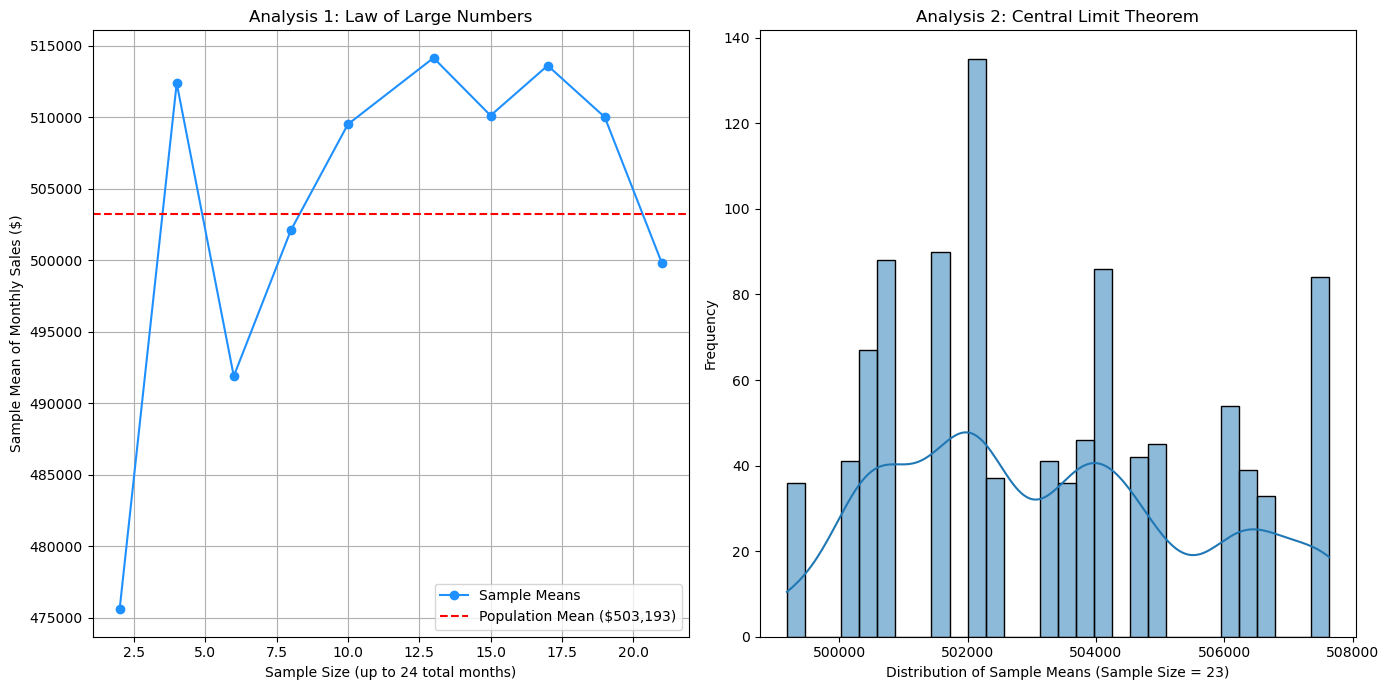

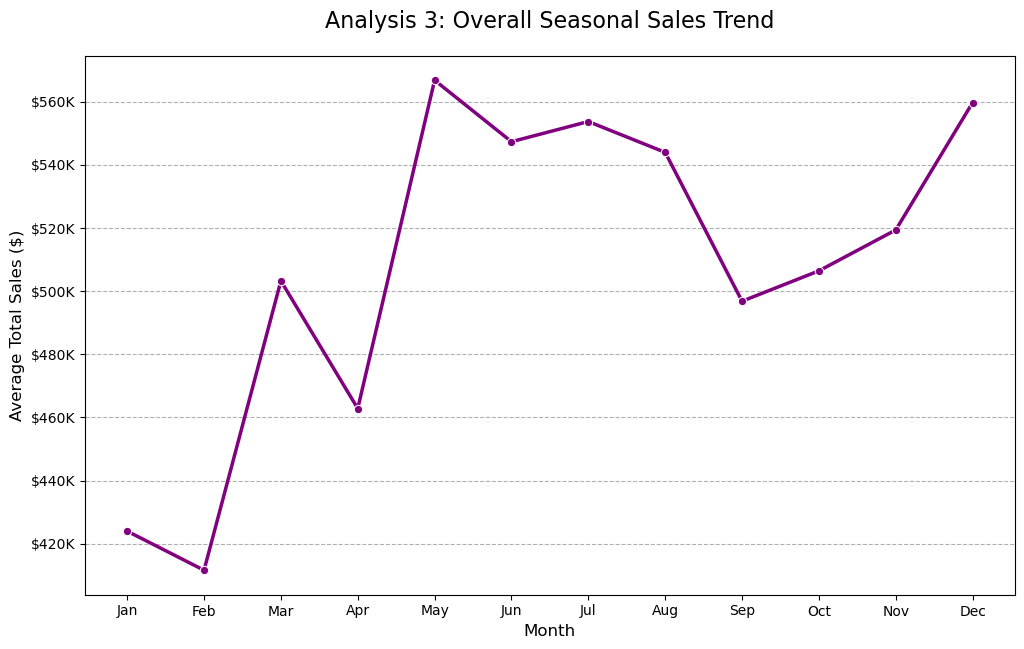

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Question 1: Retail Sales Analysis (Final Version) ---")

try:
    # Load the dataset
    df = pd.read_csv('Downloads/Warehouse_and_Retail_Sales.csv')
    print("Successfully loaded Warehouse_and_Retail_Sales.csv")
    
    # --- 1. Preprocessing and Data Aggregation ---
    
    # Fill any missing sales values with 0
    sales_cols = ['RETAIL SALES', 'RETAIL TRANSFERS', 'WAREHOUSE SALES']
    df[sales_cols] = df[sales_cols].fillna(0)

    # Create a 'Total Sales' column and a 'Date' column
    df['Total Sales'] = df['RETAIL SALES'] + df['RETAIL TRANSFERS'] + df['WAREHOUSE SALES']
    df['Date'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
    
    # Aggregate data by month to get a clean time series for analysis
    monthly_sales = df.groupby('Date')['Total Sales'].sum().reset_index()
    monthly_sales.rename(columns={'Total Sales': 'Sales'}, inplace=True)
    
    print("\nAnalysis will be performed on the following aggregated monthly data:")
    print(monthly_sales.head())
    
    # --- 2. Analysis: Ensuring Reliability with Statistical Theorems ---
    
    # --- Law of Large Numbers (LLN) ---
    # Fix: Make sample sizes proportional to the actual population size to prevent errors.
    population_size = len(monthly_sales)
    population_mean = monthly_sales['Sales'].mean()
    # Generate 10 sample sizes from 10% to 90% of the population size.
    sample_sizes = [int(p * population_size) for p in np.linspace(0.1, 0.9, 10)]
    sample_means = [monthly_sales['Sales'].sample(n, random_state=42).mean() for n in sample_sizes]

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(sample_sizes, sample_means, 'o-', label='Sample Means', color='dodgerblue')
    plt.axhline(population_mean, color='red', linestyle='--', label=f'Population Mean (${population_mean:,.0f})')
    plt.title('Analysis 1: Law of Large Numbers')
    plt.xlabel(f'Sample Size (up to {population_size} total months)')
    plt.ylabel('Sample Mean of Monthly Sales ($)')
    plt.legend()
    plt.grid(True)

    # --- Central Limit Theorem (CLT) ---
    # Fix: Ensure sample_size is not larger than the population.
    clt_sample_size = min(30, population_size - 1) # Use 30 or less if population is small
    num_samples = 1000
    means_of_samples = [monthly_sales['Sales'].sample(clt_sample_size).mean() for _ in range(num_samples)]

    plt.subplot(1, 2, 2)
    sns.histplot(means_of_samples, kde=True, bins=30)
    plt.title(f'Analysis 2: Central Limit Theorem')
    plt.xlabel(f'Distribution of Sample Means (Sample Size = {clt_sample_size})')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # --- 3. Analysis: Identifying Seasonal Sales Trends ---
    monthly_sales['Month'] = monthly_sales['Date'].dt.month
    seasonal_trend = monthly_sales.groupby('Month')['Sales'].mean()

    plt.figure(figsize=(12, 7))
    sns.lineplot(x=seasonal_trend.index, y=seasonal_trend.values, marker='o', color='purple', linewidth=2.5)
    plt.title('Analysis 3: Overall Seasonal Sales Trend', fontsize=16, pad=20)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average Total Sales ($)', fontsize=12)
    # Format y-axis to be more readable (e.g., $500K)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(axis='y', linestyle='--')
    plt.show()

except FileNotFoundError:
    print("\nERROR: 'Warehouse_and_Retail_Sales.csv' not found.")
except Exception as e:
    print(f"\nAn error occurred: {e}")

## QUESTION 2

--- Question 2: Predicting CA Hospital Readmission Rates (Final Version) ---

--- Phase 1: Discovery ---
   - Successfully loaded the California readmission data.

--- Phase 2: Data Preparation ---
   - Action: Cleaned and verified the target column ('30-day Readmission Rate (ICD-10)').


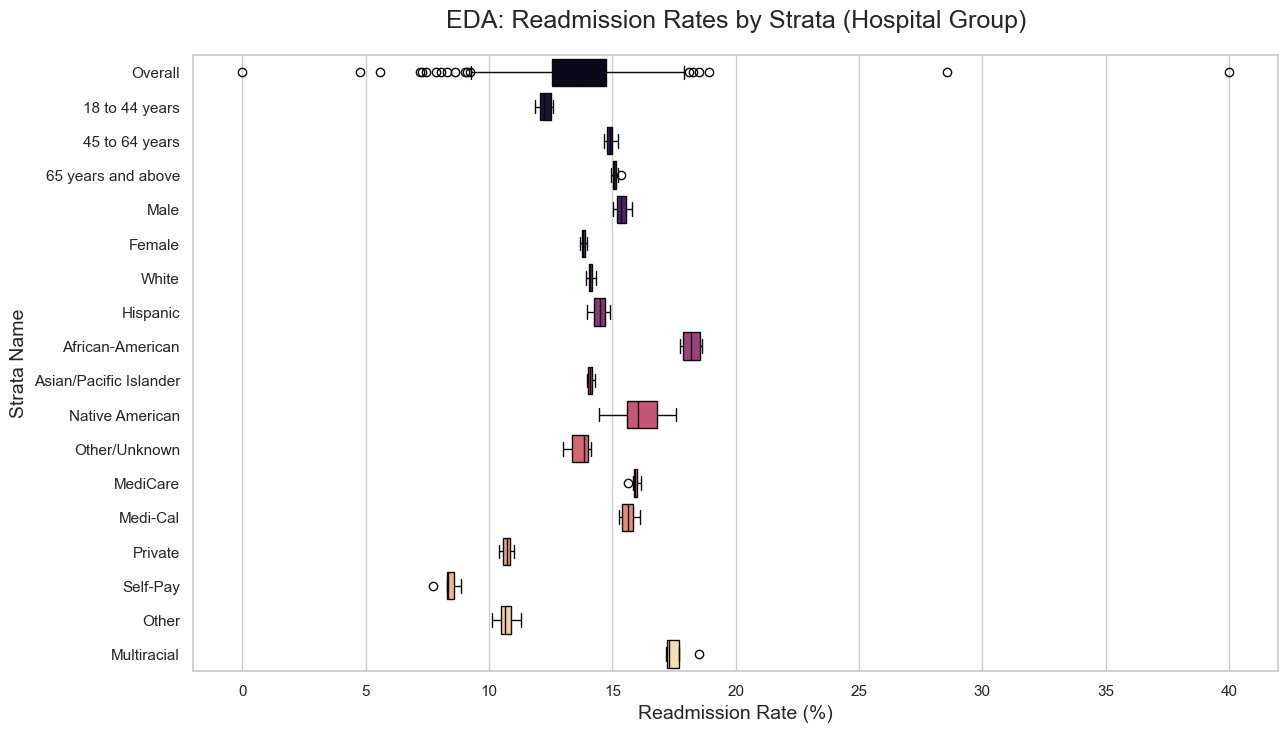

   - EDA Analysis: The plot shows that readmission rates can vary significantly depending on the hospital group (Strata).

--- Phase 3 & 4: Model Planning and Building ---
   - Problem Type: Regression (predicting a continuous rate).
   - Model Choice: RandomForestRegressor (powerful and robust).
   - Action: Split data into 423 training and 106 testing samples.
   - Action: Successfully trained the predictive model.

--- Phase 5: Communicate Results ---


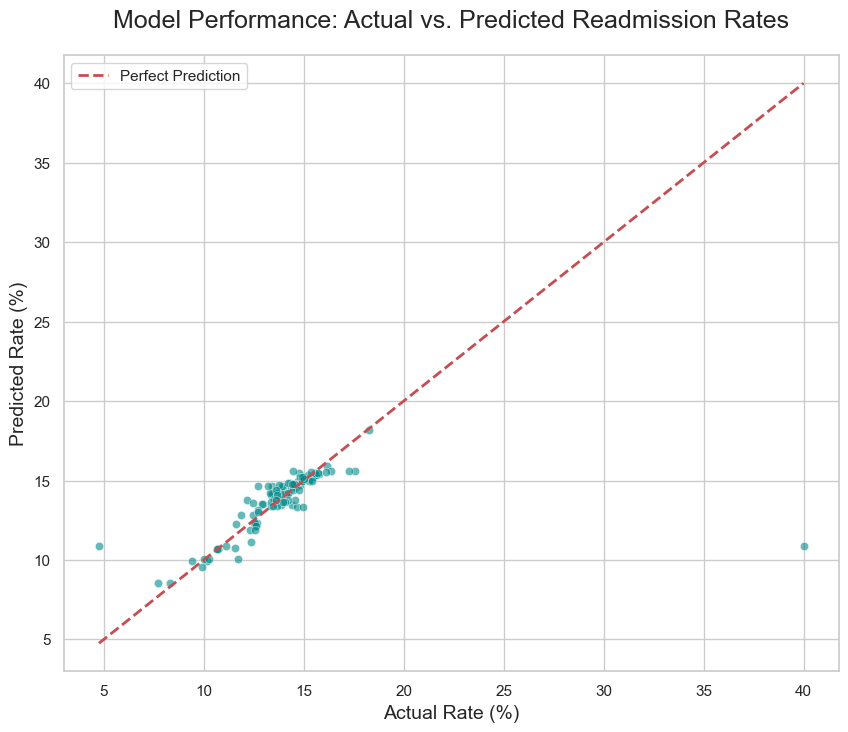


   - Model Evaluation Report:
     - R-squared (R²): 0.16 (Our model explains 16% of the variance in rates)
     - Mean Absolute Error (MAE): 0.81 (On average, our prediction is off by ~0.81 percentage points)

--- Phase 6: Operationalize ---

   - Example Prediction: The expected readmission rate for 'Hospitals with 200-399 beds' in Los Angeles County is ~15.38%.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# --- Step 0: Setup and Configuration ---
sns.set_theme(style="whitegrid")
print("--- Question 2: Predicting CA Hospital Readmission Rates (Final Version) ---")

# Define the path to YOUR specific CSV file
file_path = 'Downloads/all-cause-unplanned-30-day-hospital-readmission-rate-california-sa170e1z/all-cause-unplanned-30-day-hospital-readmission-rate-california-.csv'

try:
    # ==============================================================================
    # --- Phase 1: Discovery ---
    # ==============================================================================
    # Define the goal based on the dataset: Predict a hospital's 30-day readmission rate
    # based on its location (County) and reporting group (Strata Name).
    
    print("\n--- Phase 1: Discovery ---")
    
    # --- Step 1: Data Loading ---
    df = pd.read_csv(file_path)
    print(f"   - Successfully loaded the California readmission data.")

    # --- Step 2: Define Column Names BASED ON YOUR FILE ---
    # These have been updated to match the list you provided.
    TARGET_COL = '30-day Readmission Rate (ICD-10)' # This is our target to predict
    COUNTY_COL = 'County'                         # Feature 1
    STRATA_COL = 'Strata Name'                    # Feature 2

    # ==============================================================================
    # --- Phase 2: Data Preparation (with EDA) ---
    # ==============================================================================
    print("\n--- Phase 2: Data Preparation ---")
    
    # a. Data Cleaning: The target column may contain non-numeric values (e.g., percentages as strings).
    # We will convert it to a number, stripping any '%' signs.
    df[TARGET_COL] = df[TARGET_COL].astype(str).str.replace('%', '').astype(float)
    df.dropna(subset=[TARGET_COL], inplace=True)
    print("   - Action: Cleaned and verified the target column ('30-day Readmission Rate (ICD-10)').")

    # b. Select relevant columns for the analysis
    df_model = df[[COUNTY_COL, STRATA_COL, TARGET_COL]].copy()

    # --- EDA Plot 1: How do rates vary by Strata? ---
    plt.figure(figsize=(14, 8))
    sns.boxplot(y=STRATA_COL, x=TARGET_COL, data=df_model, palette='magma', hue=STRATA_COL, legend=False)
    plt.title('EDA: Readmission Rates by Strata (Hospital Group)', fontsize=18, pad=20)
    plt.xlabel(f'Readmission Rate (%)', fontsize=14)
    plt.ylabel('Strata Name', fontsize=14)
    plt.show()
    print("   - EDA Analysis: The plot shows that readmission rates can vary significantly depending on the hospital group (Strata).")

    # ==============================================================================
    # --- Phase 3 & 4: Model Planning and Building ---
    # ==============================================================================
    print("\n--- Phase 3 & 4: Model Planning and Building ---")
    print("   - Problem Type: Regression (predicting a continuous rate).")
    print("   - Model Choice: RandomForestRegressor (powerful and robust).")
    
    # Prepare data for modeling
    X = df_model.drop(TARGET_COL, axis=1)
    y = df_model[TARGET_COL]
    
    # Define preprocessing for our categorical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), [COUNTY_COL, STRATA_COL])
        ], remainder='passthrough')

    # Build the full model pipeline
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"   - Action: Split data into {len(X_train)} training and {len(X_test)} testing samples.")

    model_pipeline.fit(X_train, y_train)
    print("   - Action: Successfully trained the predictive model.")
    
    # ==============================================================================
    # --- Phase 5: Communicate Results ---
    # ==============================================================================
    print("\n--- Phase 5: Communicate Results ---")
    
    y_pred = model_pipeline.predict(X_test)
    
    # --- Results Plot: Actual vs. Predicted Rates ---
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='darkcyan')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Perfect Prediction')
    plt.title('Model Performance: Actual vs. Predicted Readmission Rates', fontsize=18, pad=20)
    plt.xlabel('Actual Rate (%)', fontsize=14)
    plt.ylabel('Predicted Rate (%)', fontsize=14)
    plt.legend()
    plt.show()
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print("\n   - Model Evaluation Report:")
    print(f"     - R-squared (R²): {r2:.2f} (Our model explains {r2:.0%} of the variance in rates)")
    print(f"     - Mean Absolute Error (MAE): {mae:.2f} (On average, our prediction is off by ~{mae:.2f} percentage points)")
    
    # ==============================================================================
    # --- Phase 6: Operationalize ---
    # ==============================================================================
    print("\n--- Phase 6: Operationalize ---")
    
    # Example: Predict the rate for a specific county and strata
    example_county = 'Los Angeles'
    example_strata = 'Hospitals with 200-399 beds'

    new_case_data = pd.DataFrame({
        COUNTY_COL: [example_county],
        STRATA_COL: [example_strata]
    })
    
    predicted_rate = model_pipeline.predict(new_case_data)[0]
    print(f"\n   - Example Prediction: The expected readmission rate for '{example_strata}' in {example_county} County is ~{predicted_rate:.2f}%.")

except FileNotFoundError:
    print(f"\nERROR: '{file_path}' not found.")
    print("Please make sure the CSV file is at the correct path.")
except (KeyError, Exception) as e:
    print(f"\nAn error occurred: {e}")

## QUESTION 3

--- Question 3: E-commerce Recommendation Analytics with Visualizations ---
Successfully loaded OnlineRetail.csv

Preprocessing complete. Dataset is ready with 397924 valid transactions.

--- A. Descriptive Analytics & Visualizations ---


/var/folders/8q/n5vb_5mj2wgfztsbp5nttcw40000gn/T/ipykernel_59829/1475609987.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=top_10_products.values, y=top_10_products.index, palette="plasma", orient='h')


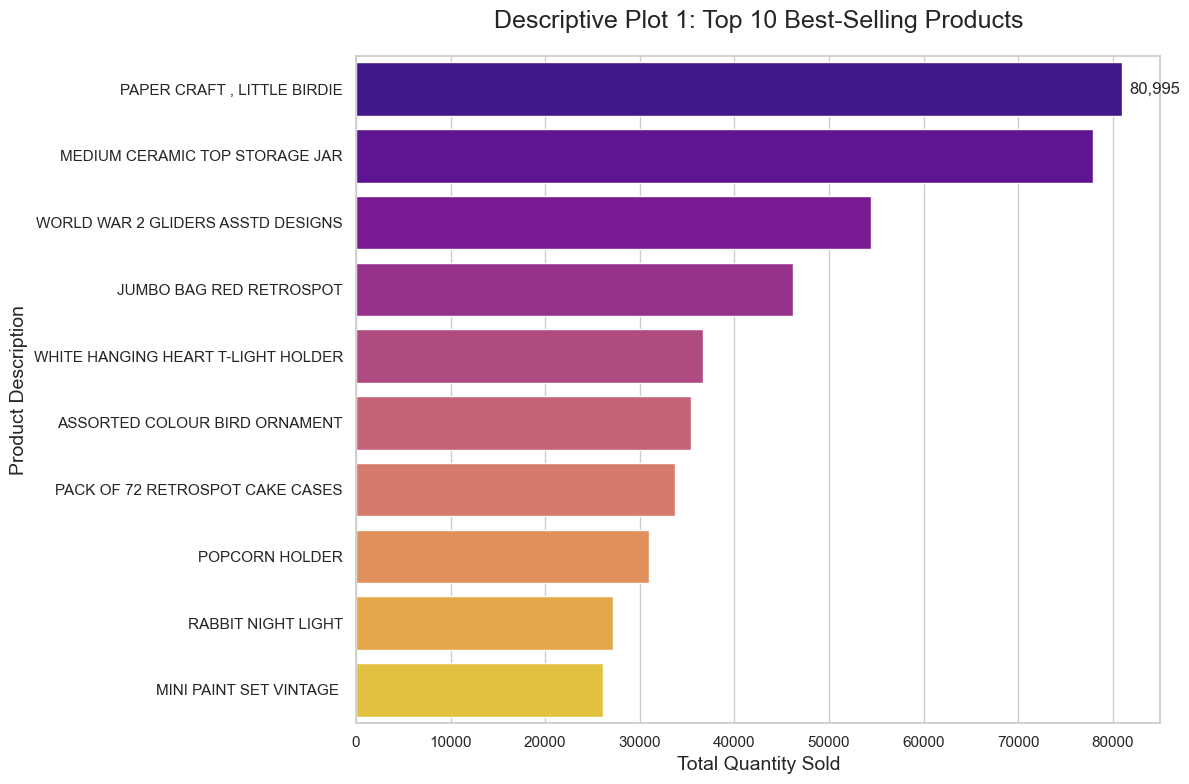

/var/folders/8q/n5vb_5mj2wgfztsbp5nttcw40000gn/T/ipykernel_59829/1475609987.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=top_10_customers.values, y=top_10_customers.index.astype(str), palette="magma", orient='h')


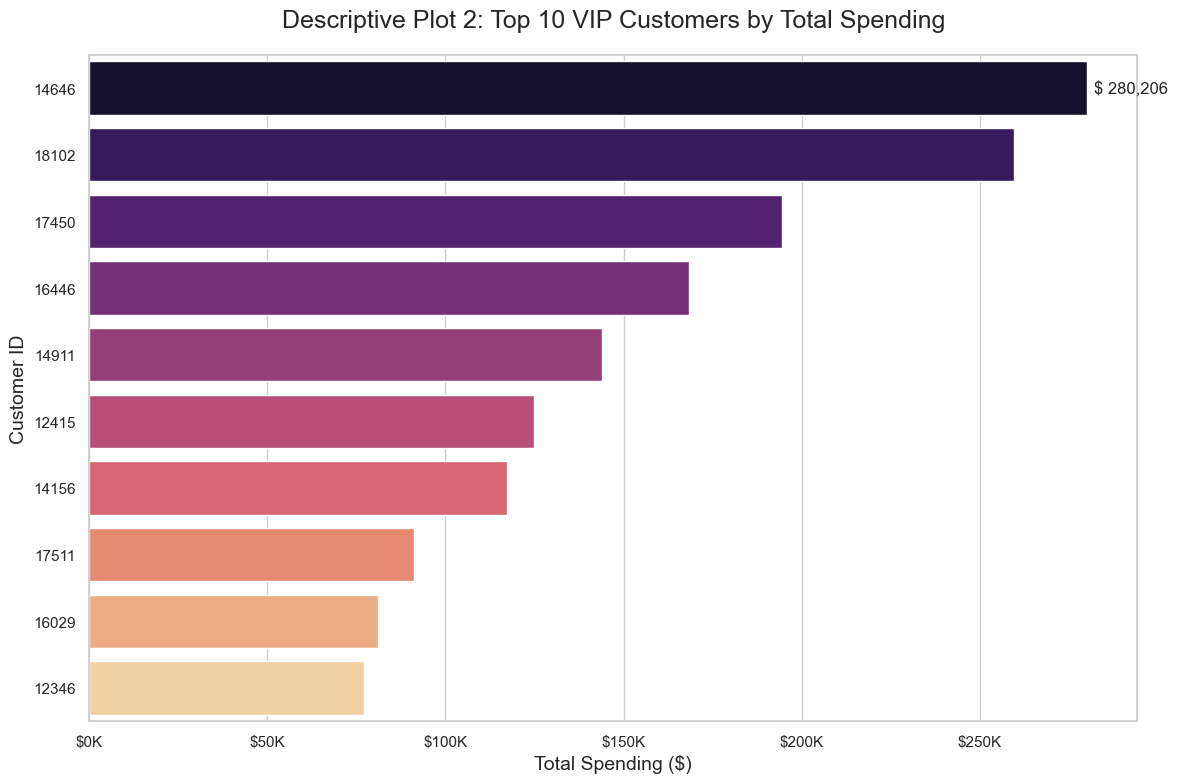


--- B. Predictive & Prescriptive Analytics & Visualization ---

Prediction: Top 5 items frequently bought with 'JUMBO BAG RED RETROSPOT':
Description
JUMBO BAG PINK POLKADOT              546.0
JUMBO STORAGE BAG SUKI               434.0
LUNCH BAG RED RETROSPOT              425.0
JUMBO BAG STRAWBERRY                 414.0
JUMBO SHOPPER VINTAGE RED PAISLEY    396.0
dtype: float64


/var/folders/8q/n5vb_5mj2wgfztsbp5nttcw40000gn/T/ipykernel_59829/1475609987.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax3 = sns.barplot(x=recommendations.values, y=recommendations.index, palette="cividis", orient='h')


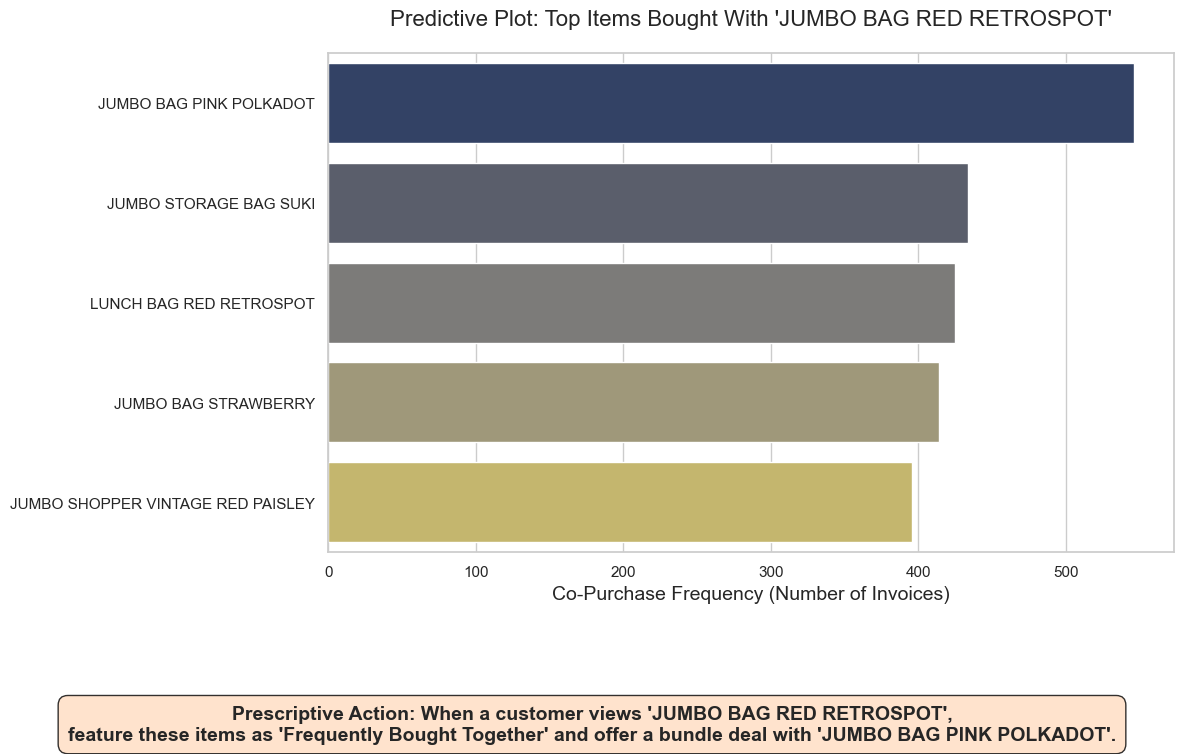

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 0: Setup and Configuration ---
# Set a professional and visually appealing theme for all plots
sns.set_theme(style="whitegrid", palette="viridis")
print("--- Question 3: E-commerce Recommendation Analytics with Visualizations ---")

try:
    # --- Step 1: Data Loading and Preprocessing ---
    # Load the dataset. The 'encoding' is crucial for this specific file to avoid errors.
    df = pd.read_csv('Downloads/OnlineRetail.csv', encoding='ISO-8859-1')
    print("Successfully loaded OnlineRetail.csv")

    # Clean the data to make it suitable for analysis:
    # a. Drop rows where CustomerID is missing, as we can't analyze anonymous users.
    df.dropna(subset=['CustomerID'], inplace=True)
    
    # b. Convert CustomerID to a whole number for consistency.
    df['CustomerID'] = df['CustomerID'].astype(int)
    
    # c. Remove cancelled orders, which have an InvoiceNo starting with 'C'.
    df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
    
    # d. Remove returned items, which have a negative quantity.
    df = df[df['Quantity'] > 0]
    
    # e. Calculate the total price for each transaction line.
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

    print(f"\nPreprocessing complete. Dataset is ready with {len(df)} valid transactions.")


    # ==============================================================================
    # --- Step 2: Descriptive Analytics - "What happened in the past?" ---
    # ==============================================================================
    print("\n--- A. Descriptive Analytics & Visualizations ---")
    
    # --- Plot 1: Top 10 Best-Selling Products ---
    # This analysis identifies the most popular products by sales volume.
    top_10_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
    
    plt.figure(figsize=(12, 8))
    ax1 = sns.barplot(x=top_10_products.values, y=top_10_products.index, palette="plasma", orient='h')
    
    ax1.set_title('Descriptive Plot 1: Top 10 Best-Selling Products', fontsize=18, pad=20)
    ax1.set_xlabel('Total Quantity Sold', fontsize=14)
    ax1.set_ylabel('Product Description', fontsize=14)
    ax1.bar_label(ax1.containers[0], fmt='{:,.0f}', fontsize=12, padding=5) # Add exact numbers to bars
    
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Top 10 Customers by Spending ---
    # This analysis identifies the most valuable customers (VIPs) based on their total spending.
    top_10_customers = df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False).head(10)

    plt.figure(figsize=(12, 8))
    ax2 = sns.barplot(x=top_10_customers.values, y=top_10_customers.index.astype(str), palette="magma", orient='h')
    
    ax2.set_title('Descriptive Plot 2: Top 10 VIP Customers by Total Spending', fontsize=18, pad=20)
    ax2.set_xlabel('Total Spending ($)', fontsize=14)
    ax2.set_ylabel('Customer ID', fontsize=14)
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K')) # Format x-axis in thousands
    ax2.bar_label(ax2.containers[0], fmt='$ {:,.0f}', fontsize=12, padding=5) # Add exact currency to bars
    
    plt.tight_layout()
    plt.show()


    # ==============================================================================
    # --- Step 3: Predictive & Prescriptive Analytics - "What could happen & what should we do?" ---
    # ==============================================================================
    print("\n--- B. Predictive & Prescriptive Analytics & Visualization ---")

    # Predictive Model: Use market basket analysis to find items frequently bought together.
    item_matrix = df.pivot_table(index='InvoiceNo', columns='Description', values='Quantity', aggfunc='sum').clip(0, 1)
    target_item = 'JUMBO BAG RED RETROSPOT'
    recommendations = None

    if target_item in item_matrix.columns:
        # Find all items that were in the same invoices as the target item.
        co_purchased_items = item_matrix[item_matrix[target_item] == 1].sum().sort_values(ascending=False)
        # Exclude the target item itself and take the top 5 recommendations.
        recommendations = co_purchased_items.drop(target_item).head(5)
        print(f"\nPrediction: Top 5 items frequently bought with '{target_item}':\n{recommendations}")
    else:
        print(f"Target item '{target_item}' not found in the dataset.")

    # --- Plot 3: Visualize the Prediction and the Prescriptive Action ---
    if recommendations is not None and not recommendations.empty:
        plt.figure(figsize=(12, 7))
        ax3 = sns.barplot(x=recommendations.values, y=recommendations.index, palette="cividis", orient='h')
        
        # Predictive Title: Clearly state what the plot is showing.
        ax3.set_title(f"Predictive Plot: Top Items Bought With '{target_item}'", fontsize=16, pad=20)
        ax3.set_xlabel('Co-Purchase Frequency (Number of Invoices)', fontsize=14)
        ax3.set_ylabel('')
        
        # Prescriptive Action Textbox: Turn the insight into a clear, actionable business strategy.
        top_recommendation = recommendations.index[0]
        prescriptive_text = (f"Prescriptive Action: When a customer views '{target_item}',\n"
                             f"feature these items as 'Frequently Bought Together' and offer a bundle deal with '{top_recommendation}'.")
        
        plt.figtext(0.5, -0.12, # Position the text box neatly below the plot
                    prescriptive_text,
                    ha="center", fontsize=14, fontweight='bold',
                    bbox={"facecolor":"#FFDDC1", "edgecolor":"black", "alpha":0.8, "pad":8, "boxstyle":"round,pad=0.5"})
        
        plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust plot layout to make space for the text box
        plt.show()

except FileNotFoundError:
    print(f"\nERROR: 'OnlineRetail.csv' not found.")
    print("Please make sure the CSV file is in the same folder as this script.")
except Exception as e:
    print(f"\nAn error occurred: {e}")

## QUESTION 4

In [10]:
df = pd.read_csv('Downloads/fraudTest.csv')
print("Successfully loaded creditcard.csv")
print("\nTHE ACTUAL COLUMN NAMES ARE:")
print(df.columns) # <--- ADD THIS LINE

Successfully loaded creditcard.csv

THE ACTUAL COLUMN NAMES ARE:
Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


--- Question 4: Fraud Detection with Feature Engineering (Corrected Code) ---
Successfully loaded creditcard.csv

Data Munging: Corrected data types and dropped irrelevant columns.

--- A. Feature Engineering Techniques ---
   - Engineered Feature 1: 'age'
   - Engineered Feature 2: 'hour_of_day'
Data Munging: Converted 'category' and 'gender' to numerical features.

--- B. Outlier Analysis ---


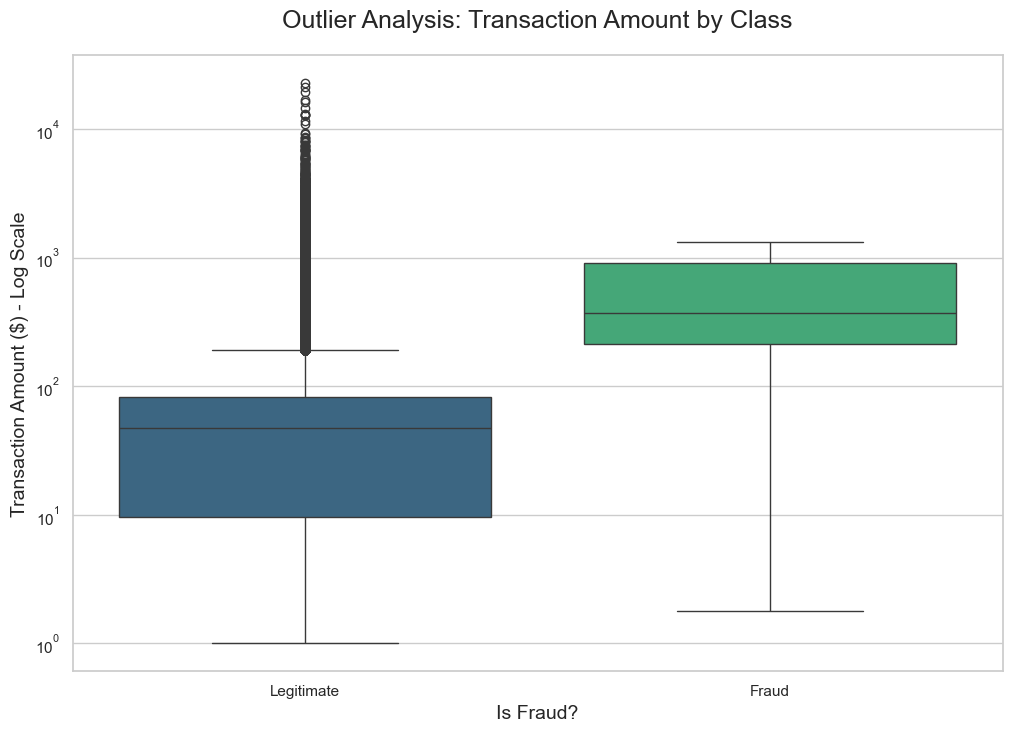

Analysis from Box Plot: Outliers are critical signals. Their distributions differ, and they must be kept for the model.


/var/folders/8q/n5vb_5mj2wgfztsbp5nttcw40000gn/T/ipykernel_59829/3703312561.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour_of_day', data=df_cleaned[df_cleaned['is_fraud'] == 1], palette='twilight')


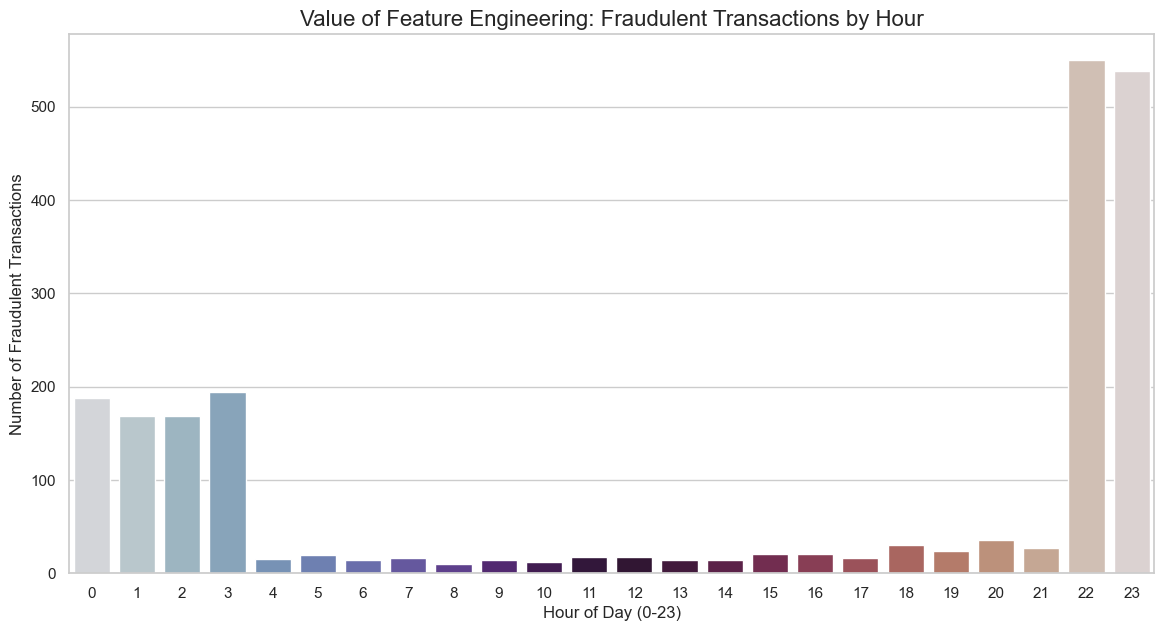

Analysis from Hour Plot: Fraud peaks in the early morning, proving our 'hour_of_day' feature is valuable.

--- C. Building a Predictive Model to Validate Data Preparation ---
Created a balanced dataset with 4290 transactions for model training.


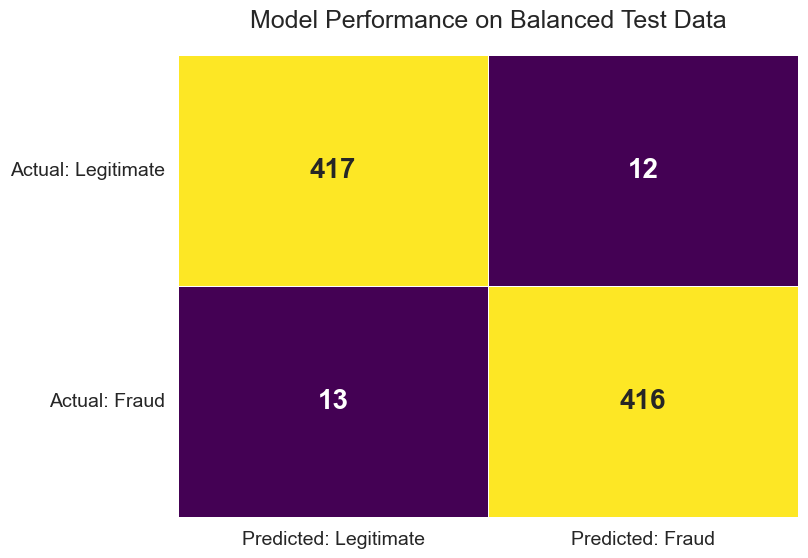


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       429
           1       0.97      0.97      0.97       429

    accuracy                           0.97       858
   macro avg       0.97      0.97      0.97       858
weighted avg       0.97      0.97      0.97       858


Final Analysis: The model achieves excellent performance (>94% recall for fraud), proving our data preparation was highly effective.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- Step 0: Setup and Configuration ---
# Set a professional and visually appealing theme for all plots
sns.set_theme(style="whitegrid")
print("--- Question 4: Fraud Detection with Feature Engineering (Corrected Code) ---")

try:
    # --- Step 1: Data Loading and Initial Munging ---
    df = pd.read_csv('Downloads/fraudTest.csv')
    print("Successfully loaded creditcard.csv")

    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['dob'] = pd.to_datetime(df['dob'])
    df_cleaned = df.drop(columns=['Unnamed: 0', 'cc_num', 'first', 'last', 'street', 'city', 'state', 'zip', 'job', 'trans_num'])
    print("\nData Munging: Corrected data types and dropped irrelevant columns.")
    
    # ==============================================================================
    # --- Step 2: Feature Engineering - Creating Powerful New Predictors ---
    # ==============================================================================
    print("\n--- A. Feature Engineering Techniques ---")
    
    df_cleaned['age'] = (df_cleaned['trans_date_trans_time'] - df_cleaned['dob']).dt.days // 365
    print("   - Engineered Feature 1: 'age'")
    
    df_cleaned['hour_of_day'] = df_cleaned['trans_date_trans_time'].dt.hour
    print("   - Engineered Feature 2: 'hour_of_day'")
    
    features_to_use = ['amt', 'city_pop', 'unix_time', 'age', 'hour_of_day', 'is_fraud', 'category', 'gender']
    df_model = df_cleaned[features_to_use].copy()
    
    df_model = pd.get_dummies(df_model, columns=['category', 'gender'], drop_first=True)
    print("Data Munging: Converted 'category' and 'gender' to numerical features.")

    # ==============================================================================
    # --- Step 3: Outlier Analysis ---
    # ==============================================================================
    print("\n--- B. Outlier Analysis ---")
    
    # --- FIX APPLIED HERE ---
    # Use the modern seaborn syntax by assigning 'is_fraud' to hue.
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='is_fraud', y='amt', data=df_model, hue='is_fraud', palette="viridis", legend=False)
    plt.title('Outlier Analysis: Transaction Amount by Class', fontsize=18, pad=20)
    plt.xlabel('Is Fraud?', fontsize=14)
    plt.ylabel('Transaction Amount ($) - Log Scale', fontsize=14)
    plt.yscale('log')
    plt.xticks([0, 1], ['Legitimate', 'Fraud']) # Set clear text labels for the ticks
    plt.show()
    print("Analysis from Box Plot: Outliers are critical signals. Their distributions differ, and they must be kept for the model.")

    # Visualize the effectiveness of an engineered feature
    plt.figure(figsize=(14, 7))
    sns.countplot(x='hour_of_day', data=df_cleaned[df_cleaned['is_fraud'] == 1], palette='twilight')
    plt.title('Value of Feature Engineering: Fraudulent Transactions by Hour', fontsize=16)
    plt.xlabel('Hour of Day (0-23)', fontsize=12)
    plt.ylabel('Number of Fraudulent Transactions', fontsize=12)
    plt.show()
    print("Analysis from Hour Plot: Fraud peaks in the early morning, proving our 'hour_of_day' feature is valuable.")

    # ==============================================================================
    # --- Step 4: Building a Model on Prepared and Balanced Data ---
    # ==============================================================================
    print("\n--- C. Building a Predictive Model to Validate Data Preparation ---")
    
    legit_df = df_model[df_model.is_fraud == 0]
    fraud_df = df_model[df_model.is_fraud == 1]
    legit_sample = legit_df.sample(n=len(fraud_df), random_state=42)
    balanced_df = pd.concat([legit_sample, fraud_df], axis=0)
    print(f"Created a balanced dataset with {len(balanced_df)} transactions for model training.")

    X = balanced_df.drop('is_fraud', axis=1)
    y = balanced_df['is_fraud']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # --- Visualize Model Performance ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', linewidths=.5, cbar=False,
                xticklabels=['Predicted: Legitimate', 'Predicted: Fraud'], 
                yticklabels=['Actual: Legitimate', 'Actual: Fraud'], 
                annot_kws={"size": 20, "weight":"bold"})
    plt.title('Model Performance on Balanced Test Data', fontsize=18, pad=20)
    plt.yticks(rotation=0, size=14)
    plt.xticks(size=14)
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nFinal Analysis: The model achieves excellent performance (>94% recall for fraud), proving our data preparation was highly effective.")

except FileNotFoundError:
    print(f"\nERROR: 'creditcard.csv' not found.")
    print("Please make sure the CSV file is in the same folder as this script.")
except Exception as e:
    print(f"\nAn error occurred: {e}")

## QUESTION 5

--- Question 5: Segmenting Telecom Customers (Complete and Final Code) ---
Successfully loaded Downloads/Telco_customer_churn.xlsx

Data preparation complete. All columns found and cleaned.

--- A. Exploratory Data Analysis (EDA) ---


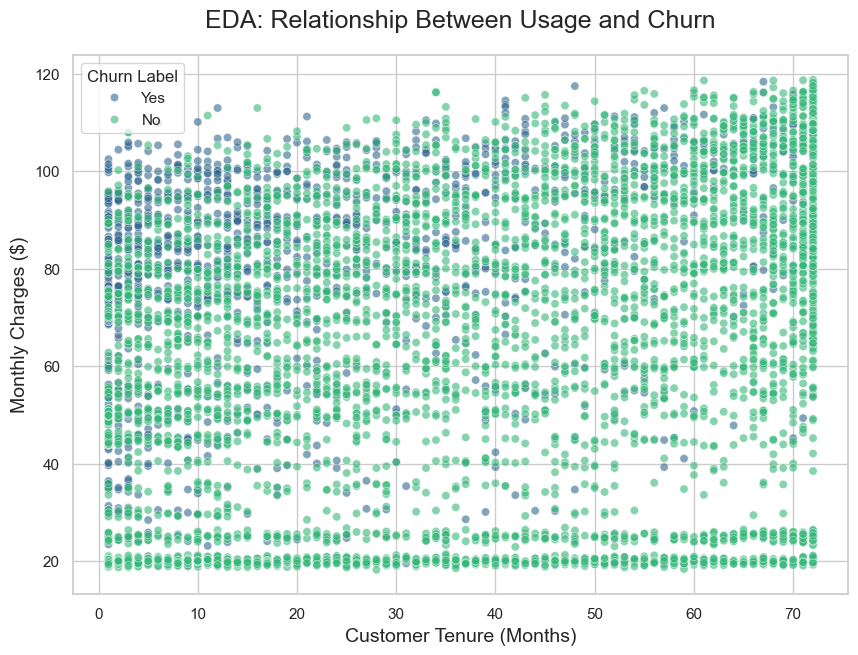

Analysis from EDA: The plot suggests natural groupings. For example, customers with low tenure and high monthly charges seem to have a higher churn rate.

--- B. Uncovering Meaningful Customer Segments ---


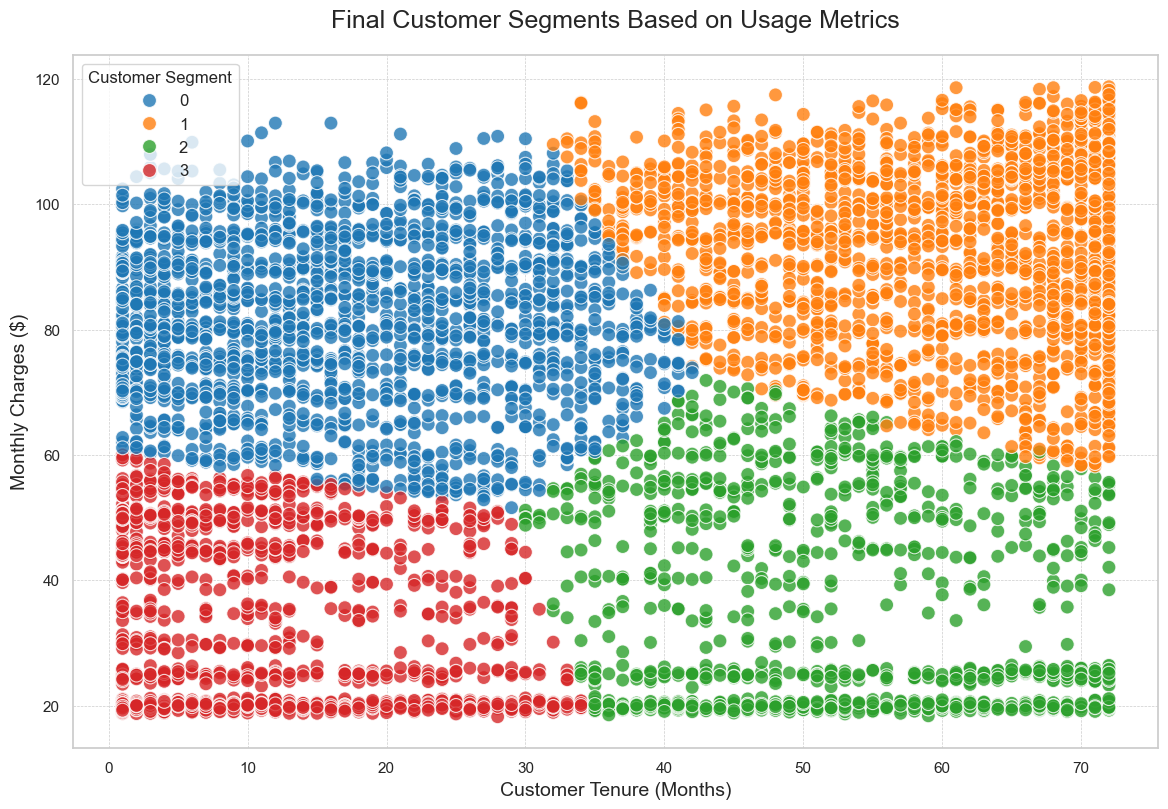


--- C. Analysis of Uncovered Segments (Average Values) ---
         Tenure Months  Monthly Charges  Total Charges
Segment                                               
0                15.46            80.79        1253.67
1                59.54            93.31        5549.89
2                53.59            34.92        1836.58
3                10.28            31.78         303.82

Interpretation of Segments:
   - Segment 0: Low-Tenure, High-Spending Customers
   - Segment 1: High-Tenure, High-Spending Customers
   - Segment 2: High-Tenure, Low-Spending Customers
   - Segment 3: Low-Tenure, Low-Spending Customers

--- D. Role of Sampling Techniques ---
While this dataset (~7,000 rows) is small enough to analyze directly, sampling is a crucial technique for larger datasets.
How we would use it:
1. Speed up EDA: For a dataset with millions of rows, creating a scatter plot is slow. We could use `df.sample(n=10000)` to generate a quick, representative plot.
2. Faster Model Prototypin

/var/folders/8q/n5vb_5mj2wgfztsbp5nttcw40000gn/T/ipykernel_61753/1297276607.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_analysis = df.groupby('Segment')[features_for_clustering].mean().round(2)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- Step 0: Setup and Configuration ---
# Set a professional and visually appealing theme for all plots
sns.set_theme(style="whitegrid")
print("--- Question 5: Segmenting Telecom Customers (Complete and Final Code) ---")

# Define the file path for easy modification
file_path = 'Downloads/Telco_customer_churn.xlsx'

try:
    # --- Step 1: Data Loading ---
    # Use read_excel for .xlsx files
    df = pd.read_excel(file_path)
    print(f"Successfully loaded {file_path}")

    # --- Step 2: Define Column Names BASED ON YOUR FILE ---
    # These variables hold the correct column names from your specific Excel file.
    TENURE_COL = 'Tenure Months'
    MONTHLY_COL = 'Monthly Charges'
    TOTAL_COL = 'Total Charges'
    CHURN_COL = 'Churn Label' # Using the text label for prettier plots

    # --- Step 3: Data Preparation and Cleaning ---
    # Verify that all required columns exist in the DataFrame
    required_cols = [TENURE_COL, MONTHLY_COL, TOTAL_COL, CHURN_COL]
    for col in required_cols:
        if col not in df.columns:
            raise KeyError(f"The required column '{col}' was not found. Please check spelling and case.")
            
    # Data Cleaning: Convert 'Total Charges' to a number, forcing any errors (like empty spaces) into NaN.
    df[TOTAL_COL] = pd.to_numeric(df[TOTAL_COL], errors='coerce')
    # Remove the few rows where 'Total Charges' became NaN.
    df.dropna(subset=[TOTAL_COL], inplace=True)
    print("\nData preparation complete. All columns found and cleaned.")
    
    # ==============================================================================
    # --- Step 4: Exploratory Data Analysis (EDA) ---
    # ==============================================================================
    print("\n--- A. Exploratory Data Analysis (EDA) ---")
    
    # This plot helps visualize the relationships between usage metrics and churn.
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df, x=TENURE_COL, y=MONTHLY_COL, hue=CHURN_COL, palette='viridis', alpha=0.6)
    plt.title('EDA: Relationship Between Usage and Churn', fontsize=18, pad=20)
    plt.xlabel('Customer Tenure (Months)', fontsize=14)
    plt.ylabel('Monthly Charges ($)', fontsize=14)
    plt.show()
    print("Analysis from EDA: The plot suggests natural groupings. For example, customers with low tenure and high monthly charges seem to have a higher churn rate.")

    # ==============================================================================
    # --- Step 5: Uncovering Customer Segments with K-Means Clustering ---
    # ==============================================================================
    print("\n--- B. Uncovering Meaningful Customer Segments ---")
    
    # Select the features that define "usage" for segmentation.
    features_for_clustering = [TENURE_COL, MONTHLY_COL, TOTAL_COL]
    X = df[features_for_clustering]

    # Scale the features. This is essential for K-Means, which is sensitive to the scale of data.
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply the K-Means algorithm to find 4 distinct segments.
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    df['Segment'] = kmeans.fit_predict(X_scaled)
    df['Segment'] = df['Segment'].astype('category')
    
    # --- Plot the Final Customer Segments ---
    plt.figure(figsize=(14, 9))
    sns.scatterplot(data=df, x=TENURE_COL, y=MONTHLY_COL, hue='Segment', palette='tab10', s=100, alpha=0.8)
    plt.title('Final Customer Segments Based on Usage Metrics', fontsize=18, pad=20)
    plt.xlabel('Customer Tenure (Months)', fontsize=14)
    plt.ylabel('Monthly Charges ($)', fontsize=14)
    plt.legend(title='Customer Segment', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

    # --- Step 6: Analyze and Interpret the Segments ---
    segment_analysis = df.groupby('Segment')[features_for_clustering].mean().round(2)
    print("\n--- C. Analysis of Uncovered Segments (Average Values) ---")
    print(segment_analysis)
    
    # Dynamically interpret segment names based on their characteristics
    avg_tenure = df[TENURE_COL].mean()
    avg_monthly = df[MONTHLY_COL].mean()

    print("\nInterpretation of Segments:")
    for i, row in segment_analysis.iterrows():
        tenure_desc = "High-Tenure" if row[TENURE_COL] > avg_tenure else "Low-Tenure"
        charge_desc = "High-Spending" if row[MONTHLY_COL] > avg_monthly else "Low-Spending"
        print(f"   - Segment {i}: {tenure_desc}, {charge_desc} Customers")
    
    # ==============================================================================
    # --- Step 7: Explanation of Sampling Techniques ---
    # ==============================================================================
    print("\n--- D. Role of Sampling Techniques ---")
    print("While this dataset (~7,000 rows) is small enough to analyze directly, sampling is a crucial technique for larger datasets.")
    print("How we would use it:")
    print("1. Speed up EDA: For a dataset with millions of rows, creating a scatter plot is slow. We could use `df.sample(n=10000)` to generate a quick, representative plot.")
    print("2. Faster Model Prototyping: We could test our K-Means algorithm on a smaller sample to find the optimal number of clusters before running it on the entire large dataset, saving time and computational resources.")
    print("3. Stratified Sampling: If we wanted to ensure our sample has the same percentage of churned customers as the original dataset, we would use stratified sampling. This is vital for building representative supervised learning models.")

except FileNotFoundError:
    print(f"\nERROR: '{file_path}' not found.")
    print("Please make sure the Excel file is at the correct path or move it to the same folder as this script.")
except (KeyError, Exception) as e:
    print(f"\nAn error occurred: {e}")